In [1]:
import numpy as np
import networkx as nx
import synthetic
from sharetrace import propagation, search
from matplotlib import pyplot as plt
import json
import pandas as pd

In [2]:
hists = synthetic.load_histories()
contacts = search.ContactSearch(min_dur=900, workers=-1).search(hists)

Number of selected pairs: 45925


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 12516 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 45350 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 45925 out of 45925 | elapsed:   26.8s finished


In [83]:
rp = propagation.RiskPropagation(parts=4)
rp._scores = len(hists)
graph, membership = rp.create_graph(contacts)
membership = np.array(membership)

In [107]:
def group_stats(stats):
    groups = []
    it = iter(stats)
    while (stat := next(it, None)) is not None:
        if 'GraphSizeInMb' in stat:
            groups.append([stat])
        else:
            groups[-1].append(stat)
    return groups

def load_stats(name: str):
    with open(f'logs//{name}.log', 'r') as f:
        stats = [json.loads(line.split('|')[-1]) for line in f.readlines()]
        return group_stats(stats)
    
def split_stats(grouped):
    gstats = pd.DataFrame([g[0] for g in grouped])
    pstats = [pd.DataFrame(g[1:]) for g in grouped]
    return gstats, pstats

def get_runtime(pstats):
    return [p['RuntimeInSec'].max() for p in pstats]

In [149]:
stats = load_stats(f'risk-propagation:ray')
_, pstats = split_stats(stats)
# runtime = get_runtime(pstats)

In [154]:
[pstats[i]['RuntimeInSec'].max() for i in range(0, 30, 3)]

[3.245,
 6.0428,
 8.8685,
 12.7645,
 17.749,
 22.0371,
 28.3689,
 43.2987,
 54.9501,
 61.3678]

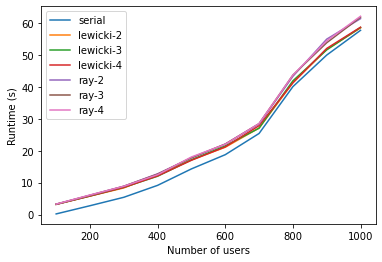

In [156]:
impls = ('serial', 'lewicki', 'ray')
pstarts = (0, 1, 2)
legend = ('serial', 'lewicki-2', 'lewicki-3', 'lewicki-4', 'ray-2', 'ray-3', 'ray-4')
for impl in impls:
    stats = load_stats(f'risk-propagation:{impl}')
    _, pstats = split_stats(stats)
    if impl == 'serial':
        runtime = get_runtime(pstats)
        runs = np.arange(1, len(runtime) + 1) * 100
        plt.plot(runs, runtime)
    else:
        for p in pstarts:
            plt.plot(runs, [pstats[i]['RuntimeInSec'].max() for i in range(p, 30, 3)])
plt.ylabel('Runtime (s)')
plt.xlabel('Number of users')
plt.legend(legend)
plt.savefig('runtime.png', dpi=300)

In [14]:
def create_matrix(n_nodes, max_degree, smeansity=0.5):
    rng = np.random.default_rng()
    binom = rng.binomial(1, p=1 - sparsity, size=(n_nodes, n_nodes))
    mat = rng.integers(1, max_degree + 1, size=(n_nodes, n_nodes))
    mat = np.triu(mat * binom, k=1)
    return np.maximum(mat, mat.T)

def compute_labels(matrix, n_clusters):
    sc = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    sc.fit(matrix)
    return sc.labels_

def draw_clusters(matrix, labels):
    network = nx.from_numpy_array(matrix)
    nx.draw(network, node_color=labels)

In [27]:
adj = np.zeros((len(hists), len(hists)))
for (v1, v2) in (e for e in graph if isinstance(e, tuple)):
    adj[v1][v2] = 1

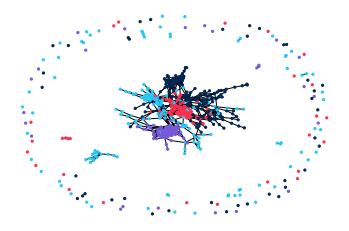

In [64]:
f = plt.figure()
network = nx.from_numpy_array(adj)
cidx = np.array(['#ff304f', '#002651', '#775ada', '#28c7fa'])
nx.draw(network, node_color=cidx[membership], node_size=5, ax=f.add_subplot(111))
f.savefig('graph.png', dpi=300)

In [77]:
nodes = np.array([v for v, data in graph.items() if not isinstance(v, tuple) and len(data['ne']) == 0])

In [97]:
import collections
counter = collections.Counter(membership[nodes])

In [98]:
counter

Counter({0: 23, 1: 34, 3: 41, 2: 22})

In [94]:
nodes[membership]

array([18, 17, 14,  7,  7, 18,  7,  7, 14,  7, 14, 14, 17,  7, 14,  7, 18,
       14,  7,  7, 18, 18,  7,  7, 14, 18,  7, 14,  7, 14, 18, 14, 18, 14,
       18, 18, 17, 14, 18, 14,  7, 18, 14, 17,  7, 17,  7, 17, 17, 18, 14,
       18,  7,  7, 18, 14, 14, 14, 17, 14, 18, 14, 17, 18, 18, 17, 17, 14,
       18,  7,  7,  7, 14,  7, 18, 14, 17, 17,  7, 17, 14, 17, 14,  7, 17,
       14, 18, 18, 18, 14, 18, 18, 14, 17, 17, 14, 14,  7,  7, 17,  7, 17,
       17,  7,  7, 17, 17, 17, 17,  7,  7,  7, 14, 17, 17, 14, 14, 14, 17,
        7,  7, 18, 14, 18, 18, 14, 14, 18, 14, 14, 17, 14, 14, 17, 14, 17,
       17, 17, 14,  7, 18, 14, 18, 18, 18, 17, 18, 14, 18, 18, 17, 17, 17,
       17, 18, 18, 14, 17, 14,  7, 18, 18, 17,  7, 14, 14, 14, 18,  7, 17,
        7, 18, 18, 17, 17,  7, 14,  7, 18,  7, 14, 14, 17,  7,  7,  7, 18,
       18, 17,  7, 17, 18,  7, 14, 18, 18,  7, 18, 17, 17, 14, 18, 17,  7,
       14, 17, 18, 17, 14, 17,  7, 14, 18,  7, 18, 18, 18, 18, 17, 18, 14,
       14, 14,  7, 14, 14

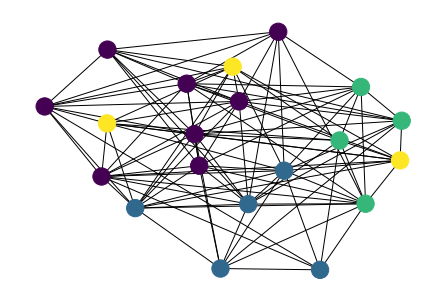

In [117]:
n_nodes = 20
n_clusters = 4
matrix = create_matrix(n_nodes, 3, sparsity=0.5)
clusters = compute_labels(matrix, n_clusters)
draw_clusters(matrix, clusters)